# Lab 7: Recurrent Neural Networks

In this tutorial, we use weather forecasting as an example for time series prediction and employ Long Short-Term Memory (LSTM) Networks, a class of Recurrent Neural Networks. The time series data is taken from the Jena Climate dataset, which consists of 14 different quantities (such as air temperature, atmospheric pressure, humidity, wind direction, and so on) recorded every 10 minutes over several years. This dataset covers data from January 1st, 2009, to December 31st, 2016 (https://www.kaggle.com/datasets/mnassrib/jena-climate).

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
csv_file_path = os.path.join(csv_path, 'jena_climate_2009_2016.csv')
df = pd.read_csv(csv_file_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


Here we only take the data for every 5 values. What do we get and why is it useful to not take all the values in the sequence?

In [ ]:
df = df[5::6]
df
# Because this is met data, i.e. once per hour is enough

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


For visualisation, we convert the time into Date Time format.

In [5]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:10:00,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
2016-12-31 20:10:00,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
2016-12-31 21:10:00,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7


Eventhough weather forcast is a multivariant time series prediction problem and having other features helps in prediction, we only need the tempreture in this example:

<Axes: xlabel='Date Time'>

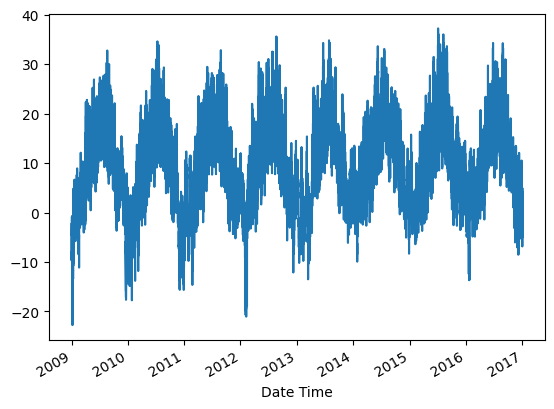

In [6]:
temp = df['T (degC)']
temp.plot()

What does the following function do?

In [ ]:
# Takes a dataframe and window size, and returns an array of arrays of temperature, and a series label for each
# The label is selected as the next value after the window, typically for supervised learning where you're 
# predicting the next temperature or label.
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
      row = [[a] for a in df_as_np[i:i+window_size]]
      X.append(row)
      label = df_as_np[i+window_size]
      y.append(label)
    return np.array(X), np.array(y)

In [24]:
WINDOW_SIZE = 50
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

X1
# y1

array([[[-8.05],
        [-8.88],
        [-8.81],
        ...,
        [-4.71],
        [-5.28],
        [-6.23]],

       [[-8.88],
        [-8.81],
        [-9.05],
        ...,
        [-5.28],
        [-6.23],
        [-6.13]],

       [[-8.81],
        [-9.05],
        [-9.63],
        ...,
        [-6.23],
        [-6.13],
        [-6.21]],

       ...,

       [[ 2.41],
        [ 1.22],
        [-0.23],
        ...,
        [-0.42],
        [-0.98],
        [-1.4 ]],

       [[ 1.22],
        [-0.23],
        [-0.87],
        ...,
        [-0.98],
        [-1.4 ],
        [-2.75]],

       [[-0.23],
        [-0.87],
        [-1.24],
        ...,
        [-1.4 ],
        [-2.75],
        [-2.89]]], shape=(70041, 50, 1))

In [9]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 50, 1), (60000,), (5000, 50, 1), (5000,), (5041, 50, 1), (5041,))

What are the possible advantages of using the values below instead?

```
train_df = temp[temp.index.year < 2015]
val_df   = temp[temp.index.year == 2015]
test_df  = temp[temp.index.year == 2016]

X_train1, y_train1 = df_to_X_y(train_df, WINDOW_SIZE)
X_val1,   y_val1   = df_to_X_y(val_df, WINDOW_SIZE)
X_test1,  y_test1  = df_to_X_y(test_df, WINDOW_SIZE)
```

The input parameter for LSTM is the number of units (or neurons) in the LSTM layer. How does it affect the prediction accuracy and training time?


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))

Compare Simple RNN, LSTM and CNN for the prediction and compare the results.

In [12]:
#Simple RNN:
#model1.add(SimpleRNN(64))

#CNN:
#model1.add(Conv1D(64, kernel_size=2, activation='relu'))
#model1.add(Flatten())

#LSTM:
model1.add(LSTM(64))

model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

How does the high and low learning rates affect the prediction accuracy?

In [13]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

What happens with high and low number of epochs?



In [14]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.7151 - root_mean_squared_error: 1.3096 - val_loss: 0.6336 - val_root_mean_squared_error: 0.7960
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6815 - root_mean_squared_error: 0.8255 - val_loss: 0.4622 - val_root_mean_squared_error: 0.6798
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6912 - root_mean_squared_error: 0.8314 - val_loss: 0.4983 - val_root_mean_squared_error: 0.7059
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6620 - root_mean_squared_error: 0.8136 - val_loss: 0.5683 - val_root_mean_squared_error: 0.7539
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6387 - root_mean_squared_error: 0.7992 - val_loss: 0.4741 - val_root_mean_squared_error: 0.6885
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6193 - root_mean_squared_error: 0.7869 - val_loss: 0.4889 - val_root_mean_squared_error: 0.6992
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('model1.keras')

In [16]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


,Train Predictions,Actuals
0,-6.732528,-6.13
1,-6.261190,-6.21
2,-6.246877,-7.02
3,-7.363195,-8.20
4,-8.996334,-8.48
...,...,...
59995,8.112224,7.97
59996,8.848136,8.78
59997,9.905047,10.33
59998,11.682335,12.35


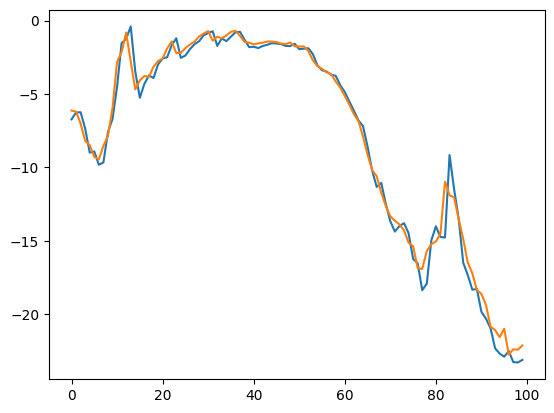

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100]) #show the prediction for only 100 times
plt.plot(train_results['Actuals'][:100])

In [18]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Val Predictions,Actuals
0,16.015448,18.13
1,18.934591,18.17
2,18.118612,17.75
3,17.148912,16.71
4,15.845364,15.67
...,...,...
4995,17.108292,17.14
4996,16.683992,17.88
4997,17.759880,17.72
4998,17.272865,17.46


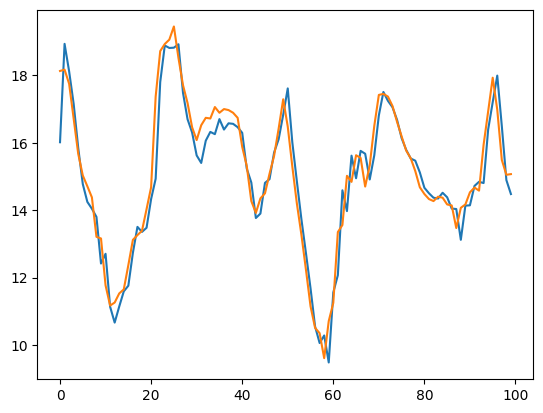

In [19]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [20]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Test Predictions,Actuals
0,17.177177,16.98
1,16.395287,15.70
2,15.015679,14.98
3,14.405684,14.09
4,13.495559,13.36
...,...,...
5036,-1.379470,-0.98
5037,-1.637938,-1.40
5038,-2.033539,-2.75
5039,-3.310699,-2.89


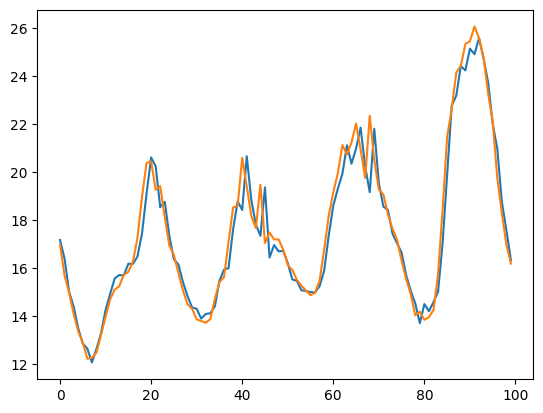

In [21]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])